In [1]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [2]:
file_path = '../Features/Rabbit_B_SHAP_RF3.xlsx'
df = pd.read_excel(file_path)
df.head()

,HallKierAlpha,BertzCT,Chi1,HeavyAtomMolWt,Chi0,ExactMolWt,NOCount,MolWt,AvgIpc,PEOE_VSA1,SlogP_VSA2,TPSA,NumHAcceptors,LabuteASA,Irritation
0,0.629273,0.334333,0.888614,0.929143,0.922773,0.963799,1.000000,0.963654,0.828191,1.000000,1.000000,1.000000,1.000000,0.870783,0
1,0.503762,0.280977,0.462399,0.434600,0.464447,0.454230,0.133333,0.454747,0.717672,0.100204,0.172717,0.092188,0.100000,0.472428,0
2,0.491727,0.226376,0.347014,0.310550,0.363924,0.323723,0.133333,0.323755,0.756701,0.063685,0.018903,0.124911,0.133333,0.343300,1
3,0.684292,0.082777,0.202972,0.173261,0.241225,0.193305,0.033333,0.193338,0.598758,0.034327,0.035499,0.042598,0.033333,0.213601,1
4,0.496885,0.177621,0.289542,0.236648,0.281479,0.246665,0.066667,0.246708,0.631675,0.077086,0.000000,0.109581,0.066667,0.272419,0


In [3]:
df.shape

(703, 15)

In [4]:
print(df.columns.to_list())

['HallKierAlpha', 'BertzCT', 'Chi1', 'HeavyAtomMolWt', 'Chi0', 'ExactMolWt', 'NOCount', 'MolWt', 'AvgIpc', 'PEOE_VSA1', 'SlogP_VSA2', 'TPSA', 'NumHAcceptors', 'LabuteASA', 'Irritation']


In [5]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  
y = df['Irritation']

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (562, 14)
Shape of X_test: (141, 14)
Shape of y_train: (562,)
Shape of y_test: (141,)


In [16]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),  
        "max_depth": trial.suggest_int("max_depth", 3, 5), 
        "min_samples_split": trial.suggest_int("min_samples_split", 10, 50, step=5),  
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 20, step=5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt"]),  
        "bootstrap": trial.suggest_categorical("bootstrap", [True]),  
        "max_samples": trial.suggest_float("max_samples", 0.5, 0.8)  
    }

    # Set up cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = RandomForestClassifier(**param, random_state=42)
        model.fit(X_train_cv, y_train_cv)
        
        # Compute validation accuracy
        valid_acc = accuracy_score(y_valid_cv, model.predict(X_valid_cv))
        valid_scores.append(valid_acc)

    # Return mean validation accuracy
    return np.mean(valid_scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)


[I 2025-05-11 18:52:10,624] A new study created in memory with name: no-name-817f0ba7-3045-4ee2-8963-d676c6fc8730
[I 2025-05-11 18:52:10,859] Trial 0 finished with value: 0.8078381795195954 and parameters: {'n_estimators': 62, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.7558743741081875}. Best is trial 0 with value: 0.8078381795195954.
[I 2025-05-11 18:52:11,125] Trial 1 finished with value: 0.8042351453855879 and parameters: {'n_estimators': 95, 'max_depth': 3, 'min_samples_split': 45, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.6772288089172209}. Best is trial 0 with value: 0.8078381795195954.
[I 2025-05-11 18:52:11,414] Trial 2 finished with value: 0.8024178255372945 and parameters: {'n_estimators': 92, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.770763936130409}. Best is trial 0 with 

Best trial: {'n_estimators': 58, 'max_depth': 5, 'min_samples_split': 25, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.789597118531772}


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
best_params = study.best_trial.params

    # Initialize the RandomForest model with the best parameters
final_model = RandomForestClassifier(**best_params)

    # Train the model
final_model.fit(X_train, y_train)


test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Predictions
y_pred = final_model.predict(X_test)

# Predict probabilities for the positive class (Irritant = 1)
probs = final_model.predict_proba(X_test)[:, 1]


# Metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Train Accuracy: 0.8398576512455516
Test Accuracy: 0.8297872340425532
Precision: 0.8133333333333334
Recall: 0.8591549295774648
F1 Score: 0.8356164383561644


In [18]:
test_accuracies = []
train_accuracies = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    best_params = study.best_trial.params

    # Initialize the RandomForest model with the best parameters
    final_model = RandomForestClassifier(**best_params)

    # Train the model
    final_model.fit(X_train, y_train)

    test_accuracy = final_model.score(X_test, y_test)
    train_accuracy = final_model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    #print("Test Accuracy:", test_accuracy)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print(np.mean(train_accuracies), np.mean(test_accuracies))

0.8375444839857652 0.823404255319149


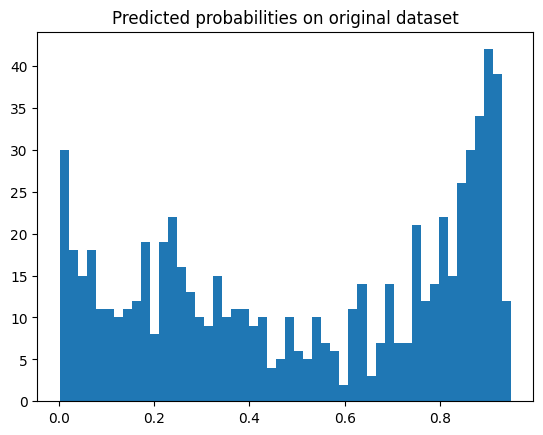

In [19]:
import matplotlib.pyplot as plt

probs = final_model.predict_proba(X)[:, 1]
plt.hist(probs, bins=50)
plt.title("Predicted probabilities on original dataset")
plt.show()


Train Accuracy: 0.8416370106761566
Test Accuracy: 0.8085106382978723


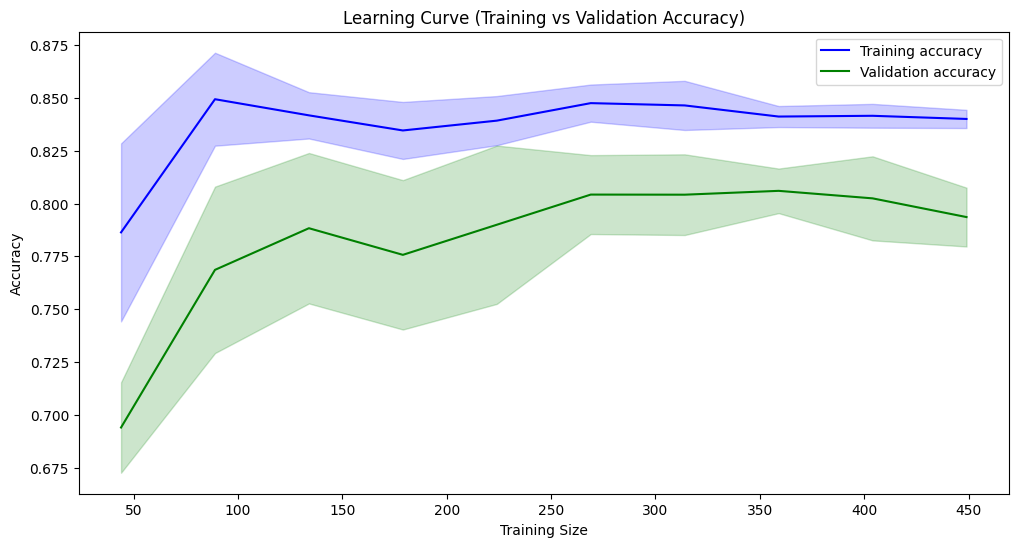

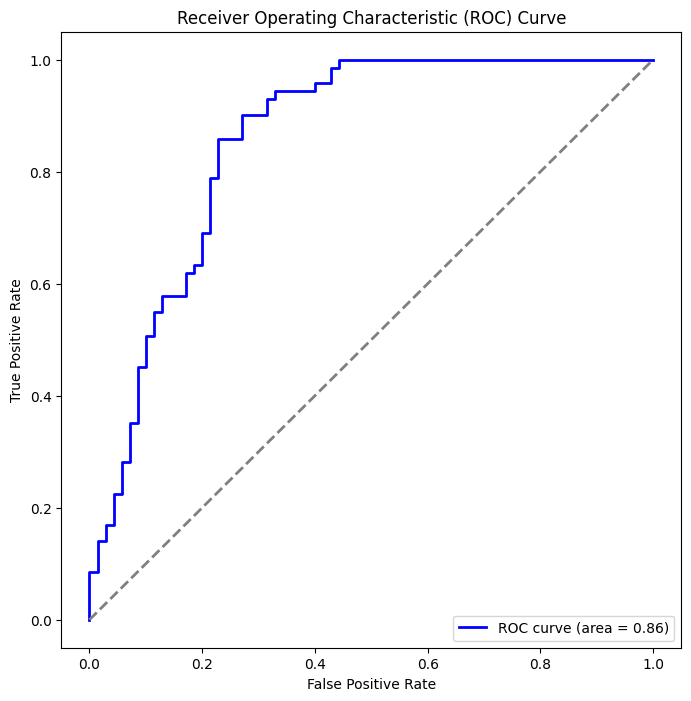

In [20]:

best_params = study.best_trial.params

# Initialize the RandomForest model with the best parameters
final_model = RandomForestClassifier(**best_params)

# Train the model
final_model.fit(X_train, y_train)

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# 1. Learning Curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 2. ROC Curve Plot
# Calculate ROC curve and AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test)[:, 1])  # Get probabilities for positive class
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [12]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)  # Shape: (samples, features, 2)

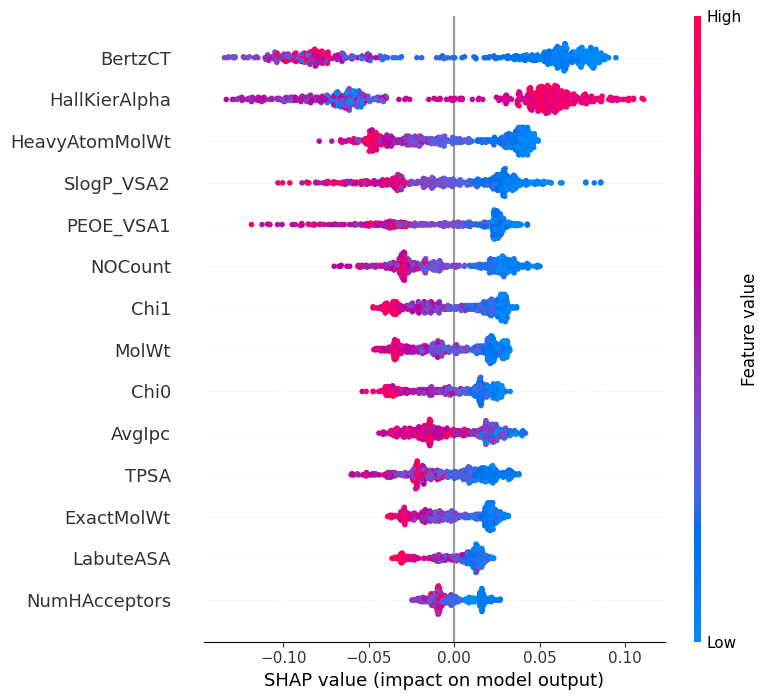

In [13]:
shap.summary_plot(shap_values[:,:,1], X_train)

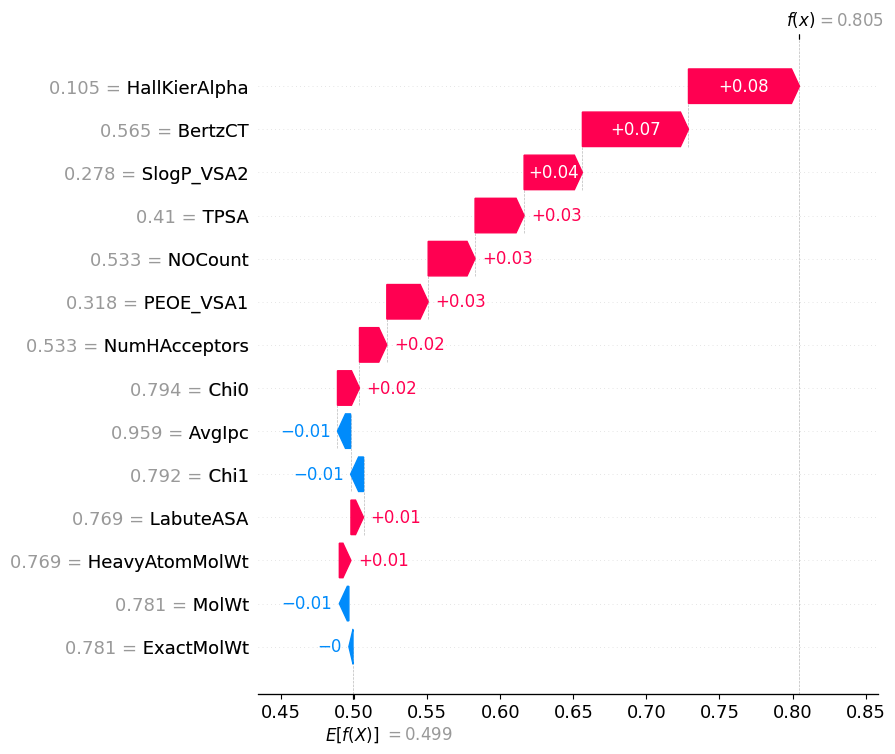

In [14]:
index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[index,:,1], base_values=explainer.expected_value[1], data=X_test.iloc[index,:]), max_display=20)

In [15]:
import joblib

joblib.dump(final_model, 'rf_model2.pkl')

print("Model saved successfully!")


Model saved successfully!
